In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from pipeline import AnomalyDetectionPipeline

In [2]:
data = 'data/2015-01-02-TOTF.PA-book.csv.gz'

In [3]:
# Initialize Pipeline
pipeline = AnomalyDetectionPipeline(seq_length=25, batch_size=128)

Pipeline initialized on device: cuda


In [4]:
# Load Data
pipeline.load_data(data)

Loading data from data/2015-01-02-TOTF.PA-book.csv.gz...


In [5]:
# Engineer Features
selected_features = ['base', 'tao', 'hawkes', 'poutre']
pipeline.engineer_features(feature_sets=selected_features)

Engineering features: ['base', 'tao', 'hawkes', 'poutre']...
Feature Engineering complete. Total features: 116


In [6]:
# Preprocess Data
pipeline.scale_and_sequence(method='minmax')

Preprocessing with method: minmax...
Data split: Train (448282, 25, 116), Test (192122, 25, 116)


In [ ]:
# Train Transformer + OC-SVM Model
pipeline.train_model(
    model_type='transformer_ocsvm', 
    epochs=2, 
    lr=1e-3,
    nu=0.01
)

# Evaluate Model
metrics_ae, cm_ae = pipeline.evaluate()

# Explainability
importance_df = pipeline.get_feature_importance(n_repeats=3)

top_20 = importance_df.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_20['Feature'], top_20['Importance'], color='#2a9d8f')
plt.xlabel('Importance Score')
plt.title('Top 20 Features driving Anomaly Detection - Transformer + OC-SVM')
plt.gca().invert_yaxis()
plt.show()

Initializing Transformer Autoencoder...
Training Autoencoder...
Epoch 1/2 - Loss: 0.006087
Epoch 2/2 - Loss: 0.001360
Extracting Latent Representations for OC-SVM...
Training One-Class SVM (nu=0.01)...


Evaluating model...
{'AUROC': 1.0, 'AUPRC': 1.0, 'F4_Score': 0.999014466723111}


<Figure size 600x600 with 0 Axes>

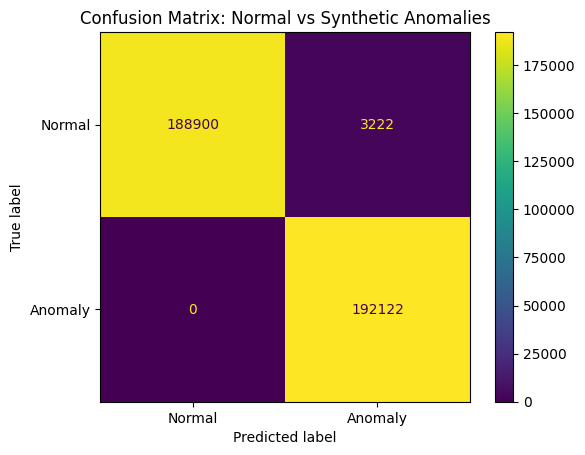

In [ ]:
# Train PNN Model
pipeline.train_model(
    model_type='pnn', 
    epochs=2, 
    lr=1e-3,
    hidden_dim=64
)

metrics_pnn, cm_pnn = pipeline.evaluate()

# Explainability
importance_df = pipeline.get_feature_importance(n_repeats=3)

top_20 = importance_df.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_20['Feature'], top_20['Importance'], color='#2a9d8f')
plt.xlabel('Importance Score')
plt.title('Top 20 Features driving Anomaly Detection - PNN')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Compare Results
metrics_df = pd.DataFrame([metrics_ae, metrics_pnn], index=['Transformer + OC-SVM', 'PNN'])
print(metrics_df)

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm_ae, display_labels=["Normal", "Anomaly"]).plot(ax=axes[0], colorbar=False)
axes[0].set_title('Transformer + OC-SVM Confusion Matrix')

ConfusionMatrixDisplay(cm_pnn, display_labels=["Normal", "Anomaly"]).plot(ax=axes[1], colorbar=False)
axes[1].set_title('PNN Confusion Matrix')

plt.tight_layout()
plt.show()

In [ ]:
# Test pipeline with Box-Cox scaler
pipeline.scale_and_sequence(method='boxcox')
pipeline.train_model(
    model_type='transformer_ocsvm', 
    epochs=2, 
    lr=1e-3,
    nu=0.01
)
metrics_boxcox, cm_boxcox = pipeline.evaluate()

In [ ]:
# Compare results with different scalers
results_df = pd.DataFrame([metrics_ae, metrics_boxcox], index=['Min-Max', 'Box-Cox'])
print(results_df)

# Plot Confusion Matrices for different scalers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_ae, display_labels=["Normal", "Anomaly"]).plot(ax=axes[0], colorbar=False)
axes[0].set_title('Min-Max Scaler Confusion Matrix')

ConfusionMatrixDisplay(cm_boxcox, display_labels=["Normal", "Anomaly"]).plot(ax=axes[1], colorbar=False)
axes[1].set_title('Box-Cox Scaler Confusion Matrix')

plt.tight_layout()
plt.show()